In [1]:
# Import necessary libraries
import tensorflow as tf

import os
import time
import pathlib
import datetime
from PIL import Image

from matplotlib import pyplot as plt
from IPython import display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Sample image size:  (256, 512, 3)


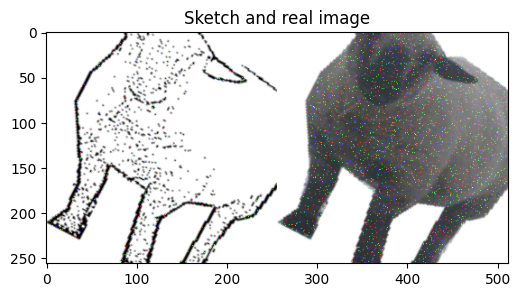

In [5]:
# Visulaize the sample image
sample_image = tf.io.read_file('/kaggle/input/animal-aug-edge-gt/10/edgeGT_10_1003_63824.png')
sample_image = tf.io.decode_png(sample_image)
print('Sample image size: ', sample_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(sample_image)
plt.title('Sketch and real image')
plt.show()

In [6]:
# Split the edge map and the real image
def load_image(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_png(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  
  edge_map = image[:, :w, :]
  real_image = image[:, w:, :]

  # Convert both images to float32 tensors
  edge_map = tf.cast(edge_map, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return edge_map, real_image

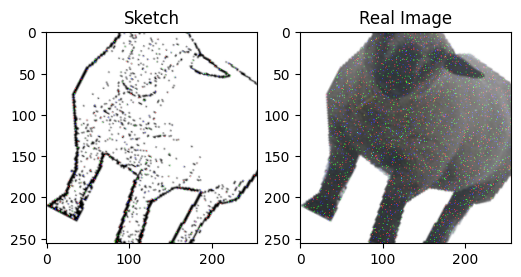

In [7]:
# Visulaize the splitted image
edge_map, real_image = load_image('/kaggle/input/animal-aug-edge-gt/10/edgeGT_10_1003_63824.png')

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(edge_map / 255.0)
plt.title('Sketch')
plt.subplot(1,2,2)
plt.imshow(real_image / 255.0)
plt.title('Real Image')
plt.show()

In [8]:
# Define parameters
BUFFER_SIZE = 1024
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
# Resize the provided edge map and image pair
def resize(edge_map, real_image, height, width):
  edge_map = tf.image.resize(edge_map, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return edge_map, real_image

In [10]:
# Randomly crop the image pairs
def random_crop(edge_map, real_image):
  stacked_image = tf.stack([edge_map, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [11]:
# Normalizing the images to [-1, 1]
def normalize(edge_map, real_image):
  edge_map = (edge_map / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return edge_map, real_image

In [12]:
# Augmentation of the training data
@tf.function()
def random_jitter(edge_map, real_image):
  # Resizing to 286x286
  edge_map, real_image = resize(edge_map, real_image, 286, 286)

  # Random cropping back to 256x256
  edge_map, real_image = random_crop(edge_map, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    edge_map = tf.image.flip_left_right(edge_map)
    real_image = tf.image.flip_left_right(real_image)

  return edge_map, real_image

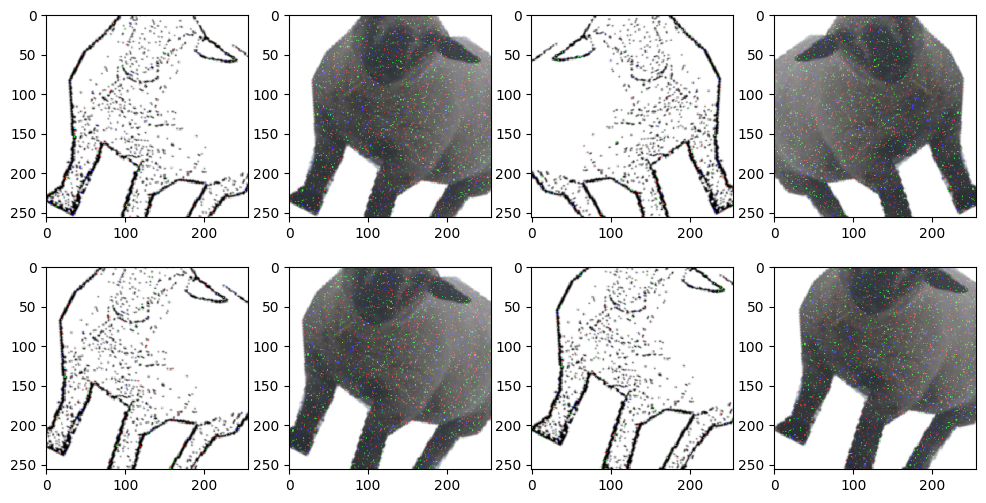

In [13]:
# Visualize the random jilter
plt.figure(figsize=(12, 6))
for i in range(4):
  rj_edge_map, rj_real_image = random_jitter(edge_map, real_image)
  
  plt.subplot(2, 4, i * 2 + 1)
  plt.imshow(rj_edge_map / 255.0)

  plt.subplot(2, 4, i * 2 + 2)
  plt.imshow(rj_real_image / 255.0)
plt.show()

In [14]:
# Load the training set
def load_train_image(image_file):
  edge_map, real_image = load_image(image_file)
  edge_map, real_image = random_jitter(edge_map, real_image)
  edge_map, real_image = normalize(edge_map, real_image)

  return edge_map, real_image

In [15]:
# Load the test set
def load_test_image(image_file):
  edge_map, real_image = load_image(image_file)
  edge_map, real_image = resize(edge_map, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  edge_map, real_image = normalize(edge_map, real_image)

  return edge_map, real_image

In [16]:
# Create a dataset from the list of image files
dataset = tf.data.Dataset.list_files('/kaggle/input/animal-aug-edge-gt/**/*.png')

# Calculate the number of images for training and testing
train_size = int(0.8 * len(list(dataset)))

# Split the dataset into training and testing
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print("Total dataset images: ", len(list(dataset)))
print("Number of train images: ", len(list(train_dataset)))
print("Number of test images: ", len(list(test_dataset)))

Total dataset images:  31335
Number of train images:  25068
Number of test images:  6267


In [17]:
# Prepare the training dataset
train_dataset = train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [18]:
# Prepare the test dataset
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

****Generator Model****

In [19]:
# The pix2pix generator is based in U-net architecture with downsampling and upsampling
OUTPUT_CHANNELS = 3

# Define the downsample layers
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [20]:
# Define the upsampling layers
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [21]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

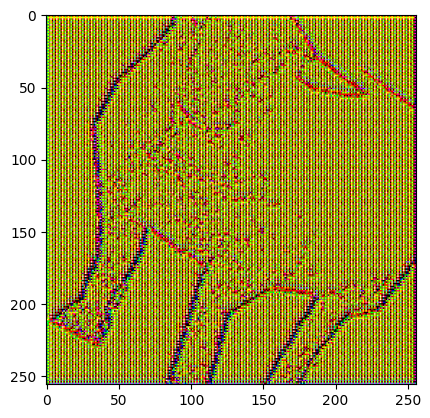

In [23]:
gen_output = generator(edge_map[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
# plt.savefig("generated.png", dpi=512, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [24]:
# Define the generator loss
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

***Disriminator Model***

In [25]:
# Define the discriminator network
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [26]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

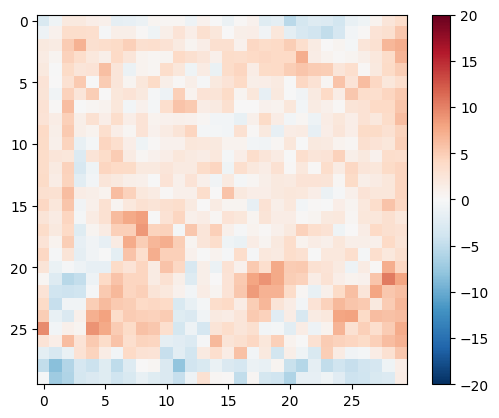

In [27]:
disc_out = discriminator([gen_output, real_image[tf.newaxis, ...]], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
# plt.savefig("discriminator.png", dpi=512, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [25]:
# Define the discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
checkpoint_dir = '/kaggle/working/Checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs('/kaggle/working/Image/', exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
def generate_images(model, test_input, target):
  prediction = model(test_input, training=True)
  
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], prediction[0], target[0]]
  title = ['Input Image', 'Generated Image', 'Ground Truth']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

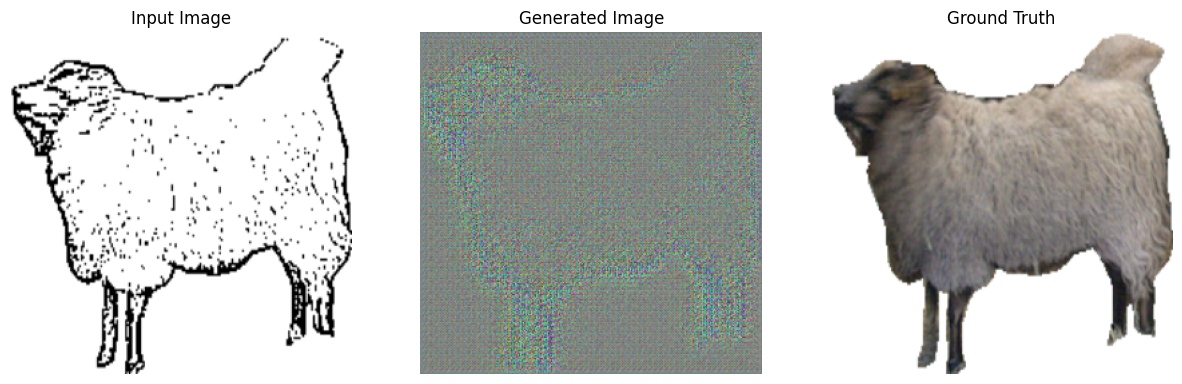

In [29]:
for edge_map, target in test_dataset.take(1):
  generate_images(generator, edge_map, target)

In [30]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [31]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
    tf.summary.scalar('disc_loss', disc_loss, step=step)

In [32]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    
    if (step == 0) or ((step+1) % 500 == 0):
      generated = generator(example_input, training=True)
      
      edge = (example_input * 0.5 + 0.5) * 255.0
      edge = tf.cast(edge, dtype=tf.uint8)
      edge = edge.numpy()
      edge = Image.fromarray(edge[0])
    
      generated = ((generated + 1)/2) * 255.0
      generated = tf.cast(generated, dtype=tf.uint8)
      generated = generated.numpy()
      generated = Image.fromarray(generated[0])

      GT = (example_target * 0.5 + 0.5) * 255.0
      GT = tf.cast(GT, dtype=tf.uint8)
      GT = GT.numpy()
      GT = Image.fromarray(GT[0])    

      concatenated_image = Image.new('RGB', (768, 256))
      concatenated_image.paste(edge, (0, 0))
      concatenated_image.paste(generated, (256, 0))
      concatenated_image.paste(GT, (512, 0))
  
      filename = f'training_image_{step+1}.png'
      output_path = os.path.join('/kaggle/working/Image/', filename)
      concatenated_image.save(output_path)

Time taken for 1000 steps: 54.45 sec



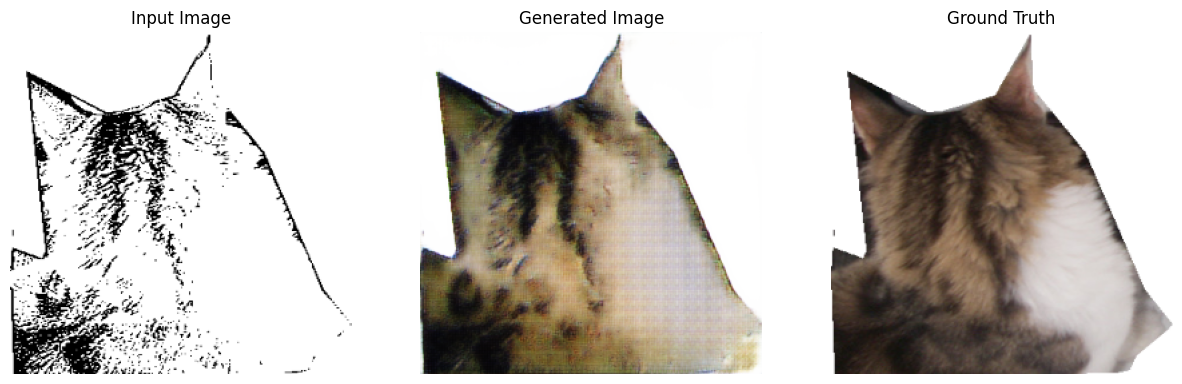

Step: 25k
......

In [33]:
fit(train_dataset, test_dataset, steps=train_size)

In [34]:
generator.save('generator_animal_25k', save_format='tf')

In [35]:
generator.save('generator_animal_25k.keras')

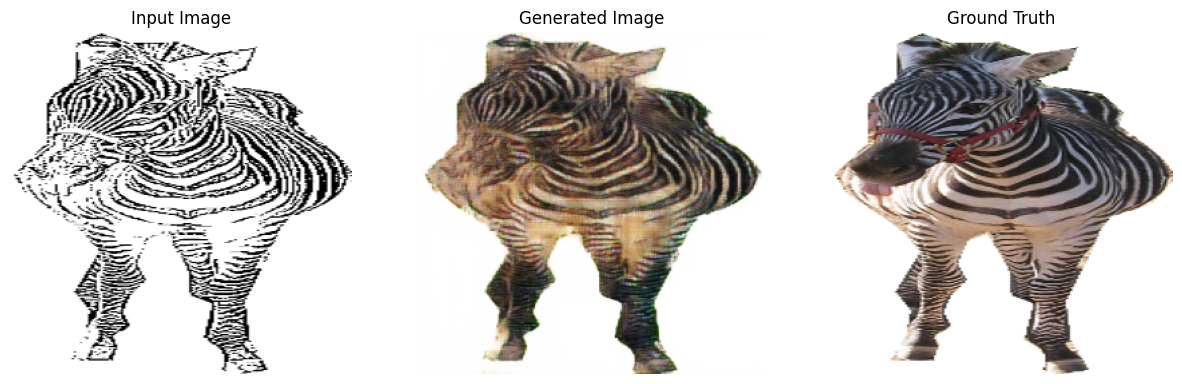

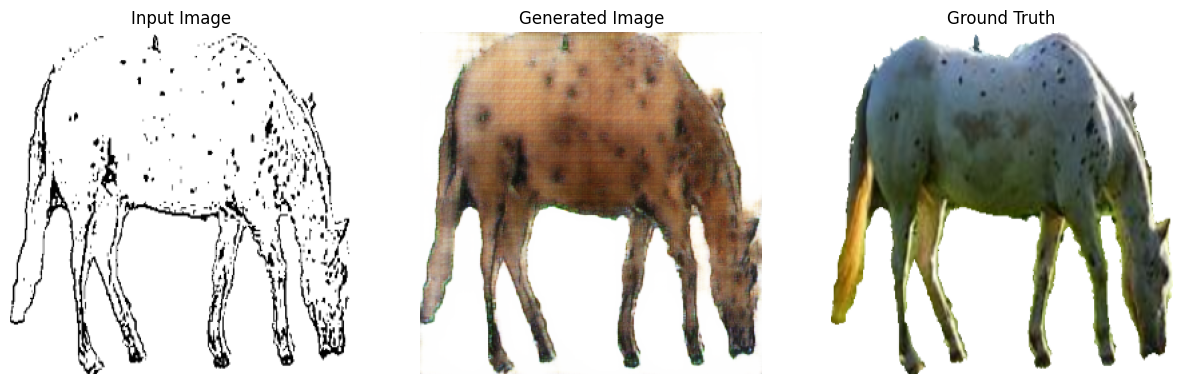

In [50]:
for edge_map, target in test_dataset.take(2):
  generate_images(generator, edge_map, target)